# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
sns.set(style="whitegrid")

## Import Data

In [89]:
#Read in data
df = pd.read_csv('kc_house_data_train.csv')
holdout = pd.read_csv('kc_house_data_test_features.csv')

In [90]:
#Drop Unnamed and id columns
df = df.drop(['Unnamed: 0','id'],axis=1)

## Exploratory Data Analysis 
    

First, I review the correlation between all the features within our dataset. Normally, we review for collinearity within these charts, but for now, we can initially see which variables have the strongest relationship with 'price'.

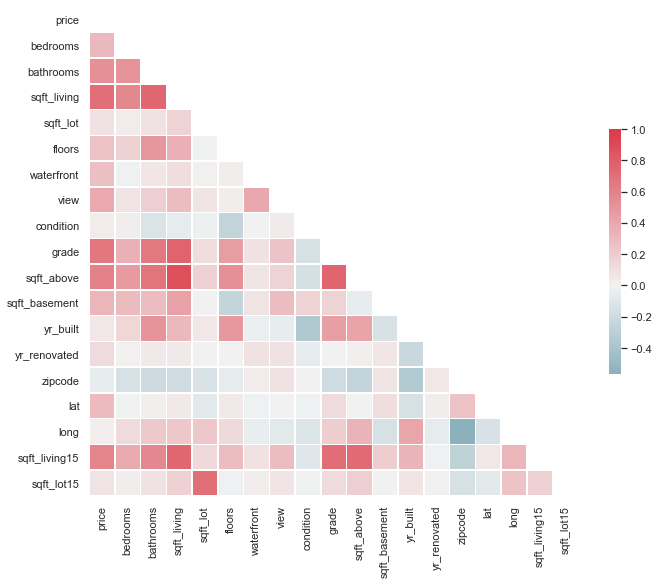

In [5]:
#style setting
sns.set(style="white")

# Calculate correlation
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib\
f, ax = plt.subplots(figsize=(11, 9))

# Use colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

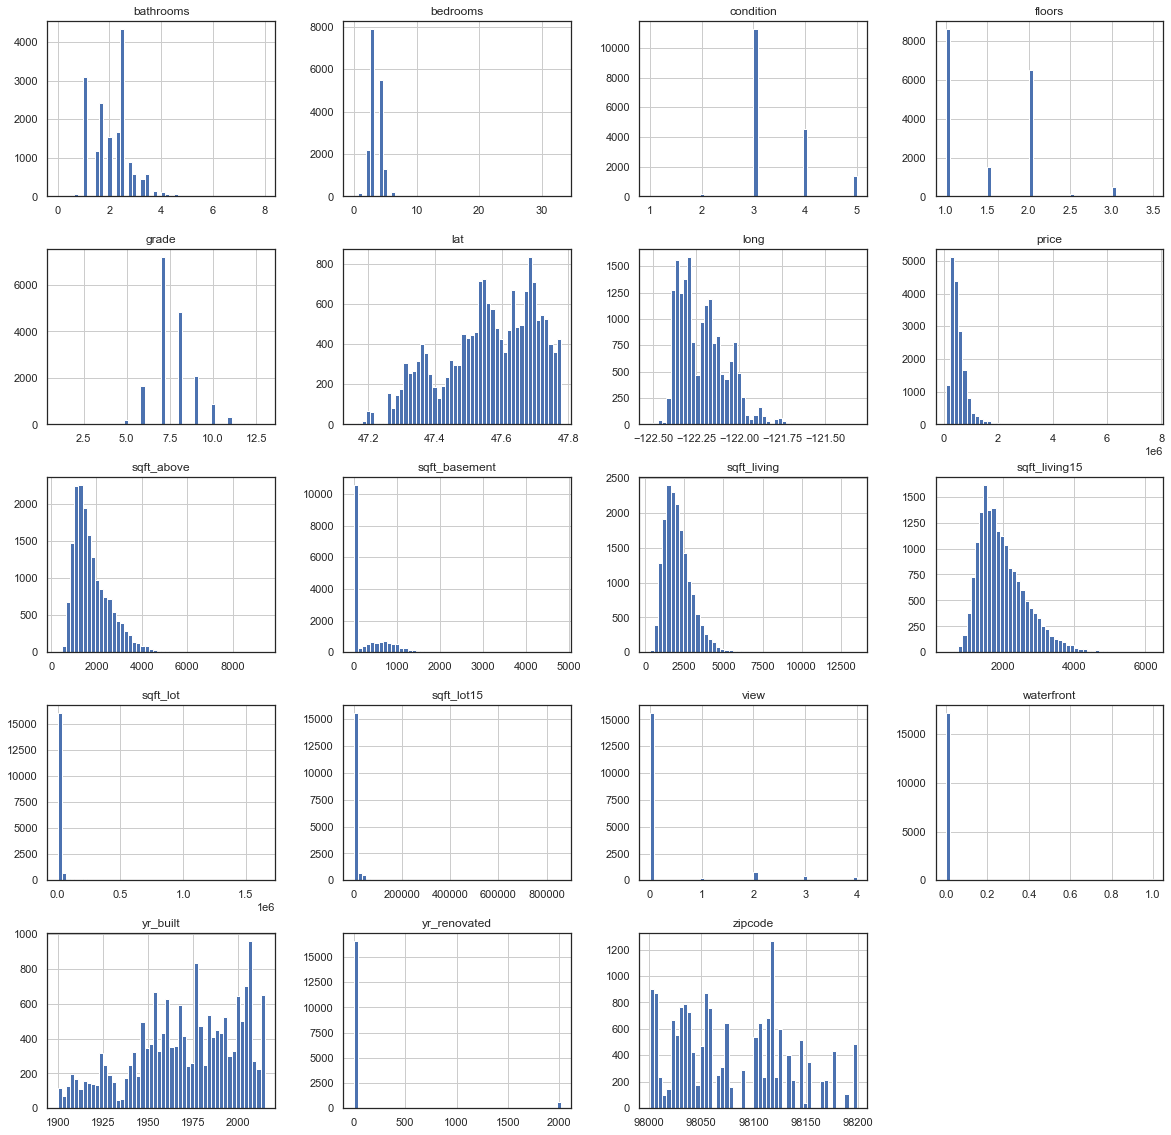

In [6]:
df.hist(bins=50,figsize=(20,20))
plt.show()

### Relationship between House Prices and Sqft of Living Space

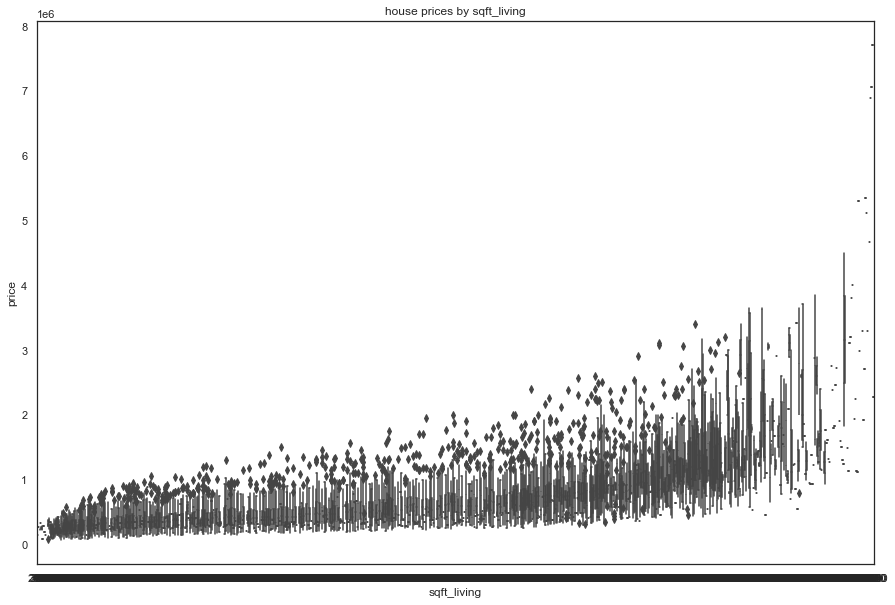

In [15]:
#Plotting house prices vs sqft_living
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(15,10))
plt.title('house prices by sqft_living')
plt.xlabel('sqft_living')
plt.ylabel('house prices')
sns.boxplot(x='sqft_living',y='price',data=df)

### Relationship between House Prices and Number of Bathrooms

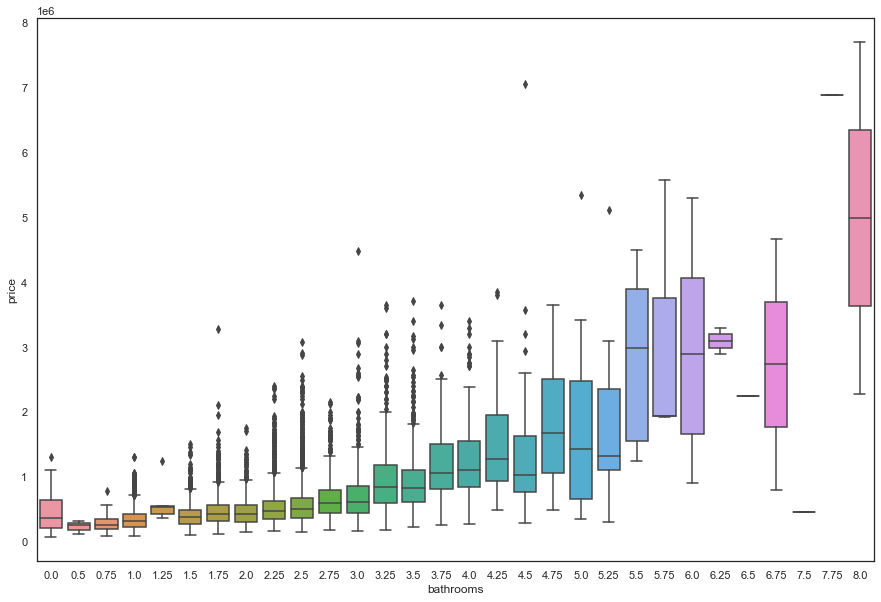

In [16]:
#Plotting house prices vs # of bathrooms
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='bathrooms',y='price',data=df);

### Relationship between House Prices and Number of Bedrooms

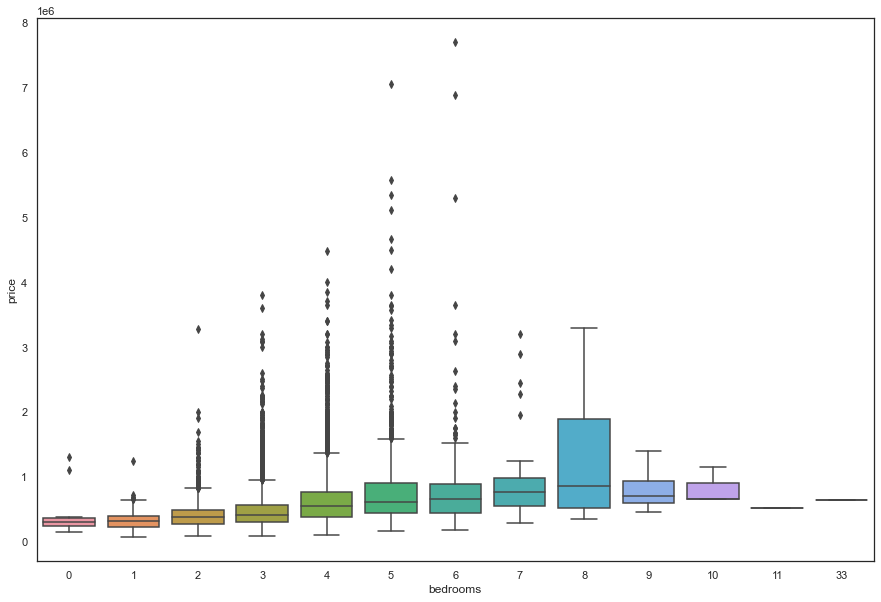

In [17]:
#Plotting house prices vs # of bedrooms
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='bedrooms',y='price',data=df);

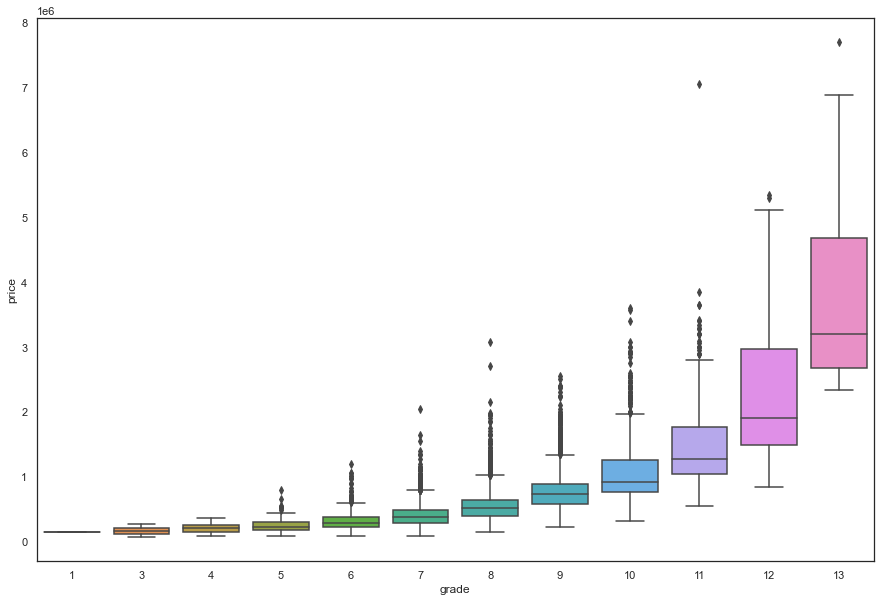

In [18]:
#Plotting house prices vs sqft_living
fig,axes=plt.subplots(1,1,figsize=(15,10))
sns.boxplot(x='grade',y='price',data=df);

## Date Adjustment and Data Cleanup

In [19]:
#Date Conversion
df['month'] = df['date'].str[4:6]
df['month'] = pd.to_numeric(df['month'],errors='coerce')
df = df.drop(['date'],axis=1)

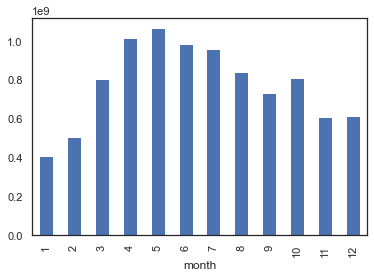

In [20]:
df.groupby(['month']).price.sum().plot(kind='bar');

In [21]:
#Check data for any NA values
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
years_old        0
renovated        0
month            0
dtype: int64

In [22]:
df['bedrooms'].value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [23]:
#Outlier Data in Bedrooms removed
df = df[df['bedrooms']<=10]
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,renovated,month
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,29,0,10
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,38,0,8
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,18,0,8
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,25,0,3
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,11,0,7


## Initial Linear Regression

Create a linear regression plot using all basic data in the initial dataset

In [24]:
target = df['price']
features = df.columns.drop(['price'])
df_features = df[features]
df_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,renovated,month
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,29,0,10
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,38,0,8
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,18,0,8
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,25,0,3
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,11,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,57,0,3
17286,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,67,0,5
17287,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,62,0,5
17288,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,44,0,12


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 206735.39698886572


## Additional Feature Generation

### Create Dummy Variables for Zipcode

In [26]:
#ziplist = df['zipcode'].tolist()
#ziplist_series = pd.Series(ziplist)
#ziplist_final = ziplist_series.astype('category')
#zip_dummies = pd.get_dummies(ziplist_final)
#df = pd.concat([df,zip_dummies], axis=1)
#df = df[df['bedrooms'].notna()]

### Create new years_old column from yr_built column

In [27]:
#Years Old column created
df['years_old'] = 2015-df['yr_built']

### Create new renovated column from yr_renovated column

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,renovated,month
0,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,98058,47.4388,-122.162,2390,7700,29,0,10
1,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,98115,47.6784,-122.285,2370,6283,38,0,8
2,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,98006,47.5646,-122.129,3710,9685,18,0,8
3,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,98034,47.6995,-122.228,4050,14226,25,0,3
4,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,98052,47.6647,-122.083,2250,4050,11,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,98008,47.5858,-122.112,2730,10400,57,0,3
17286,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,98105,47.6687,-122.288,1350,4013,67,0,5
17287,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,98028,47.7635,-122.262,1760,9403,62,0,5
17288,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,98038,47.4199,-121.990,2080,108028,44,0,12


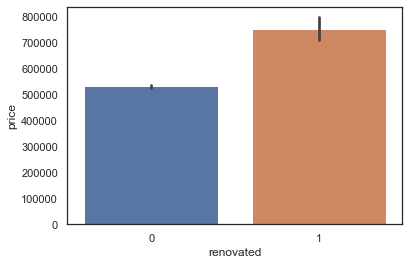

In [28]:
#Renovated Year column converted to binary variable "Renovated"
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
sns.barplot(x='renovated',y='price',data=df);
df.drop('yr_renovated',axis=1)

In [29]:
#Test statistical significance of newly created renovated value
stat= stats.ttest_ind(df[df.renovated == 1].price,
                df[df.renovated == 0].price, 
                equal_var=False)
print(f'T-Test shows a stastically significant difference between the mean of homes that have gone through renovations compared to those without with a p_value of {stat[1]}')

T-Test shows a stastically significant difference between the mean of homes that have gone through renovations compared to those without with a p_value of 6.390567577920582e-20


In [30]:
target = df['price']
features = df.columns.drop(['price'])
df_features = df[features]

In [31]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_features, target, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train2, y_train2)

y_train2_pred = lm.predict(X_train2)

train2_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_train2_pred))

print('Training Root Mean Squared Error:' , train2_rmse)

Training Root Mean Squared Error: 206735.39698886572


## <ins>Non-linear transformations</ins>

Test the polynomial nature of bedrooms, bathrooms,sqft of living on the price.

In [23]:
df2 = df
df2['bedrooms^2'] = df['bedrooms']**2
df2['bathrooms^2'] = df['bathrooms']**2
df2['sqft^2'] = df['sqft_living']**2

In [24]:
target2 = df2['price']
features = df2.columns.drop(['price'])
df2_features = df2[features]

In [25]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df2_features, target2, random_state=9,test_size=0.2)

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train3, y_train3)

y_train3_pred = lm.predict(X_train3)

train3_rmse = np.sqrt(metrics.mean_squared_error(y_train3, y_train_pred))

print('Training Root Mean Squared Error:' , train3_rmse)

Training Root Mean Squared Error: 207108.55473142033


In [32]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,renovated,month,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms yr_built,bedrooms yr_renovated,bedrooms zipcode,bedrooms lat,bedrooms long,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms years_old,bedrooms renovated,bedrooms month,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms view,bathrooms condition,bathrooms grade,bathrooms sqft_above,bathrooms sqft_basement,bathrooms yr_built,bathrooms yr_renovated,bathrooms zipcode,bathrooms lat,bathrooms long,bathrooms sqft_living15,bathrooms sqft_lot15,bathrooms years_old,bathrooms renovated,bathrooms month,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living condition,sqft_living grade,sqft_living sqft_above,sqft_living sqft_basement,sqft_living yr_built,sqft_living yr_renovated,sqft_living zipcode,sqft_living lat,sqft_living long,sqft_living sqft_living15,sqft_living sqft_lot15,sqft_living years_old,sqft_living renovated,sqft_living month,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot view,sqft_lot condition,sqft_lot grade,sqft_lot sqft_above,sqft_lot sqft_basement,sqft_lot yr_built,sqft_lot yr_renovated,sqft_lot zipcode,sqft_lot lat,sqft_lot long,sqft_lot sqft_living15,sqft_lot sqft_lot15,sqft_lot years_old,sqft_lot renovated,sqft_lot month,floors^2,floors waterfront,floors view,floors condition,floors grade,floors sqft_above,floors sqft_basement,floors yr_built,floors yr_renovated,floors zipcode,floors lat,floors long,floors sqft_living15,floors sqft_lot15,floors years_old,floors renovated,floors month,waterfront^2,waterfront view,waterfront condition,waterfront grade,waterfront sqft_above,waterfront sqft_basement,waterfront yr_built,waterfront yr_renovated,waterfront zipcode,waterfront lat,waterfront long,waterfront sqft_living15,waterfront sqft_lot15,waterfront years_old,waterfront renovated,waterfront month,view^2,view condition,view grade,view sqft_above,view sqft_basement,view yr_built,view yr_renovated,view zipcode,view lat,view long,view sqft_living15,view sqft_lot15,view years_old,view renovated,view month,condition^2,condition grade,condition sqft_above,condition sqft_basement,condition yr_built,condition yr_renovated,condition zipcode,condition lat,condition long,condition sqft_living15,condition sqft_lot15,condition years_old,condition renovated,condition month,grade^2,grade sqft_above,grade sqft_basement,grade yr_built,grade yr_renovated,grade zipcode,grade lat,grade long,grade sqft_living15,grade sqft_lot15,grade years_old,grade renovated,grade month,sqft_above^2,sqft_above sqft_basement,sqft_above yr_built,sqft_above yr_renovated,sqft_above zipcode,sqft_above lat,sqft_above long,sqft_above sqft_living15,sqft_above sqft_lot15,sqft_above years_old,sqft_above renovated,sqft_above month,sqft_basement^2,sqft_basement yr_built,sqft_basement yr_renovated,sqft_basement zipcode,sqft_basement lat,sqft_basement long,sqft_basement sqft_living15,sqft_basement sqft_lot15,sqft_basement years_old,sqft_basement renovated,sqft_basement month,yr_built^2,yr_built yr_renovated,yr_built zipcode,yr_built lat,yr_built long,yr_built sqft_living15,yr_built sqft_lot15,yr_built years_old,yr_built renovated,yr_built month,yr_renovated^2,yr_renovated zipcode,yr_renovated lat,yr_renovated long,yr_renovated sqft_living15,yr_renovated sqft_lot15,yr_renovated years_old,yr_renovated renovated,yr_renovated month,zipcode^2,zipcode lat,zipcode long,zipcode sqft_living15,zipcode sqft_lot15,zipcode years_old,zipcode renovated,zipcode month,lat^2,lat long,lat sqft_living15,lat sqft_lot15,lat years_old,lat renovated,lat month,long^2,long sqft_living15,long sqft_l

In [49]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(df_poly2, target, random_state=9,test_size=0.2)

In [75]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(x_train4, y_train4)

y_train4_pred = lm_2.predict(x_train4)
y_test4_pred = lm_2.predict(x_test4)

train4_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_train4_pred))
test4_rmse = np.sqrt(metrics.mean_squared_error(y_test4, y_test4_pred))
print('Training Root Mean Squared Error:' , train4_rmse)
print('Testing Root Mean Squared Error:' , test4_rmse)

Training Root Mean Squared Error: 152562.89296740186
Testing Root Mean Squared Error: 153216.52158656114


The poly2 model has outperformed all previous models with a RSME Of 152567.6

In [34]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(df_features)
poly3_columns = poly_3.get_feature_names(df_features.columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
df_poly3.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,years_old,renovated,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms yr_built,bedrooms yr_renovated,bedrooms zipcode,bedrooms lat,bedrooms long,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms month,bedrooms years_old,bedrooms renovated,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms view,bathrooms condition,bathrooms grade,bathrooms sqft_above,bathrooms sqft_basement,bathrooms yr_built,bathrooms yr_renovated,bathrooms zipcode,bathrooms lat,bathrooms long,bathrooms sqft_living15,bathrooms sqft_lot15,bathrooms month,bathrooms years_old,bathrooms renovated,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living condition,sqft_living grade,sqft_living sqft_above,sqft_living sqft_basement,sqft_living yr_built,sqft_living yr_renovated,sqft_living zipcode,sqft_living lat,sqft_living long,sqft_living sqft_living15,sqft_living sqft_lot15,sqft_living month,sqft_living years_old,sqft_living renovated,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot view,sqft_lot condition,sqft_lot grade,sqft_lot sqft_above,sqft_lot sqft_basement,sqft_lot yr_built,sqft_lot yr_renovated,sqft_lot zipcode,sqft_lot lat,sqft_lot long,sqft_lot sqft_living15,sqft_lot sqft_lot15,sqft_lot month,sqft_lot years_old,sqft_lot renovated,floors^2,floors waterfront,floors view,floors condition,floors grade,floors sqft_above,floors sqft_basement,floors yr_built,floors yr_renovated,floors zipcode,floors lat,floors long,floors sqft_living15,floors sqft_lot15,floors month,floors years_old,floors renovated,waterfront^2,waterfront view,waterfront condition,waterfront grade,waterfront sqft_above,waterfront sqft_basement,waterfront yr_built,waterfront yr_renovated,waterfront zipcode,waterfront lat,waterfront long,waterfront sqft_living15,waterfront sqft_lot15,waterfront month,waterfront years_old,waterfront renovated,view^2,view condition,view grade,view sqft_above,view sqft_basement,view yr_built,view yr_renovated,view zipcode,view lat,view long,view sqft_living15,view sqft_lot15,view month,view years_old,view renovated,condition^2,condition grade,condition sqft_above,...,yr_renovated zipcode years_old,yr_renovated zipcode renovated,yr_renovated lat^2,yr_renovated lat long,yr_renovated lat sqft_living15,yr_renovated lat sqft_lot15,yr_renovated lat month,yr_renovated lat years_old,yr_renovated lat renovated,yr_renovated long^2,yr_renovated long sqft_living15,yr_renovated long sqft_lot15,yr_renovated long month,yr_renovated long years_old,yr_renovated long renovated,yr_renovated sqft_living15^2,yr_renovated sqft_living15 sqft_lot15,yr_renovated sqft_living15 month,yr_renovated sqft_living15 years_old,yr_renovated sqft_living15 renovated,yr_renovated sqft_lot15^2,yr_renovated sqft_lot15 month,yr_renovated sqft_lot15 years_old,yr_renovated sqft_lot15 renovated,yr_renovated month^2,yr_renovated month years_old,yr_renovated month renovated,yr_renovated years_old^2,yr_renovated years_old renovated,yr_renovated renovated^2,zipcode^3,zipcode^2 lat,zipcode^2 long,zipcode^2 sqft_living15,zipcode^2 sqft_lot15,zipcode^2 month,zipcode^2 years_old,zipcode^2 renovated,zipcode lat^2,zipcode lat long,zipcode lat sqft_living15,zipcode lat sqft_lot15,zipcode lat month,zipcode lat years_old,zipcode lat renovated,zipcode long^2,zipcode long sqft_living15,zipcode long sqft_lot15,zipcode long month,zipcode long years_old,zipcode long renovated,zipcode sqft_living15^2,zipcode sqft_living15 sqft_lot15,zipcode sqft_living15 month,zipcode sqft_living15 years_old,zipcode sqft_living15 renovated,zipcode sqft_lot15^2,zipcode sqft_lot15 month,zipcode sqft_lot15 years_old,z

In [35]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(df_poly3, target, random_state=9,test_size=0.2)

In [37]:
# instantiate a linear regression object
lm_3 = LinearRegression()

#fit the linear regression to the data
lm_3 = lm_3.fit(X_train5, y_train5)

y_train5_pred = lm_3.predict(X_train5)

train5_rmse = np.sqrt(metrics.mean_squared_error(y_train5, y_train5_pred))

print('Training Root Mean Squared Error:' , train5_rmse)

Training Root Mean Squared Error: 124917.38101254584


The poly3 table has the highest RSME value however, the data becomes convoluted and creates too many columns. I believe this model is not going to be reasonable and the poly2 model is superior.

## F Test

Determine Best Features to Narrow down to Top 20 Variables

In [37]:
x_train4.shape

(13830, 252)

In [67]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=20)

selector.fit(x_train4, y_train4)

SelectKBest(k=20, score_func=<function f_regression at 0x0000014803BEB310>)

In [71]:
selected_columns = x_train4.columns[selector.get_support()]
removed_columns = x_train4.columns[~selector.get_support()]

In [79]:
lm_kbest = LinearRegression()

lm_kbest = lm_kbest.fit(x_train4[selected_columns], y_train4)

y_train_kbest = lm_kbest.predict(x_train4[selected_columns])


trainK4_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK4_rmse)

y_kbest = lm_kbest.predict(x_test4[selected_columns])

testK4_rmse = np.sqrt(metrics.mean_squared_error(y_test4, y_kbest))

print('Testing Root Mean Squared Error:' , testK5_rmse)

Training Root Mean Squared Error: 191256.33801592755
Testing Root Mean Squared Error: 201894.165052656


In [83]:
print('Original: ', test4_rmse, '\n',
      "KBest:   ", testK5_rmse,'\n')
print("Original has a lower RSME than KBest")

Original:  153216.52158656114 
 KBest:    201894.165052656 

Original has a lower RSME than KBest


In [85]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2, target)

In [86]:
lm_final.coef_

array([ 4.74957176e+00, -1.15126428e+02, -9.22179016e+02, -6.09100547e+02,
       -1.08931306e+03, -1.70510056e+03,  1.94784893e+02,  4.06402628e+01,
       -6.92687453e+01,  6.74875223e+01, -3.43439892e+01, -1.43736753e+01,
        2.52047966e+01,  1.11716624e+00,  4.43153916e+01, -2.10711368e+01,
        3.49631212e+00, -1.24331345e+01,  1.53245284e+01, -1.18285538e+03,
       -5.24566959e+00,  1.34379456e+03,  2.19399727e+03, -1.72644625e+01,
        9.96967159e-03,  2.40921018e+04,  2.74174799e+03,  3.46123052e+03,
       -3.36278316e+03, -4.08505130e+02, -1.34218277e+01, -6.64374563e+00,
        4.65648407e+03,  5.36191940e+02,  1.09706653e+01, -3.20252413e+04,
        7.32883143e+04,  1.38534752e+01,  1.01482055e-01,  4.91756460e+03,
       -1.08449278e+06,  3.19557516e+02,  1.03022848e+03,  4.66988456e+00,
       -4.09859658e-01, -3.07685837e+04,  6.35721019e+04,  6.48368055e+03,
       -8.03555654e+03,  1.64253141e+04,  1.58547443e+01, -1.12014068e+01,
       -1.41233422e+03, -

In [87]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()